# building and training transformer with just pytorch

Transformer predicts next most possible word (token)

bigram: distribution of characters


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
import random
import matplotlib.pyplot as plt
import time


what we need to build a sequence generator
stoi
itos
distribution of each char
limited predictability, limited use

Attention mechanism

语言的本质是什么？
想象一个婴儿是如何知道我们说一个词比如飞机的时候，在说什么？
下意识的答案是我们指给他看飞机这一物件。但婴儿看到飞机时又是如何理解这一物件的呢？当我们将飞机的发音和飞机物件挂上钩时，婴儿并不能真正理解飞机。语言是依托于整个人类的系统，或者说是文明。

深层次是概念的区别。我们理解飞机通过汽车，通过飞行和行驶的二元对立，通过天空和地面的二元对立。换句话说，


In [ ]:
from PyPDF2 import PdfReader
import re
reader = PdfReader('ISDA.pdf')
for i in range(len(reader.pages)):
    page = reader.pages[i]
    text += page.extract_text()
raw_text = re.sub(r'[^\w]', ' ', text).lower().split()
number_unique_char =len(set(re.sub(r'[^\w]', ' ', text).lower()))


In [57]:
N = torch.zeros((number_unique_char, number_unique_char), dtype=torch.int32)
chars = sorted(list(set(''.join(raw_text))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

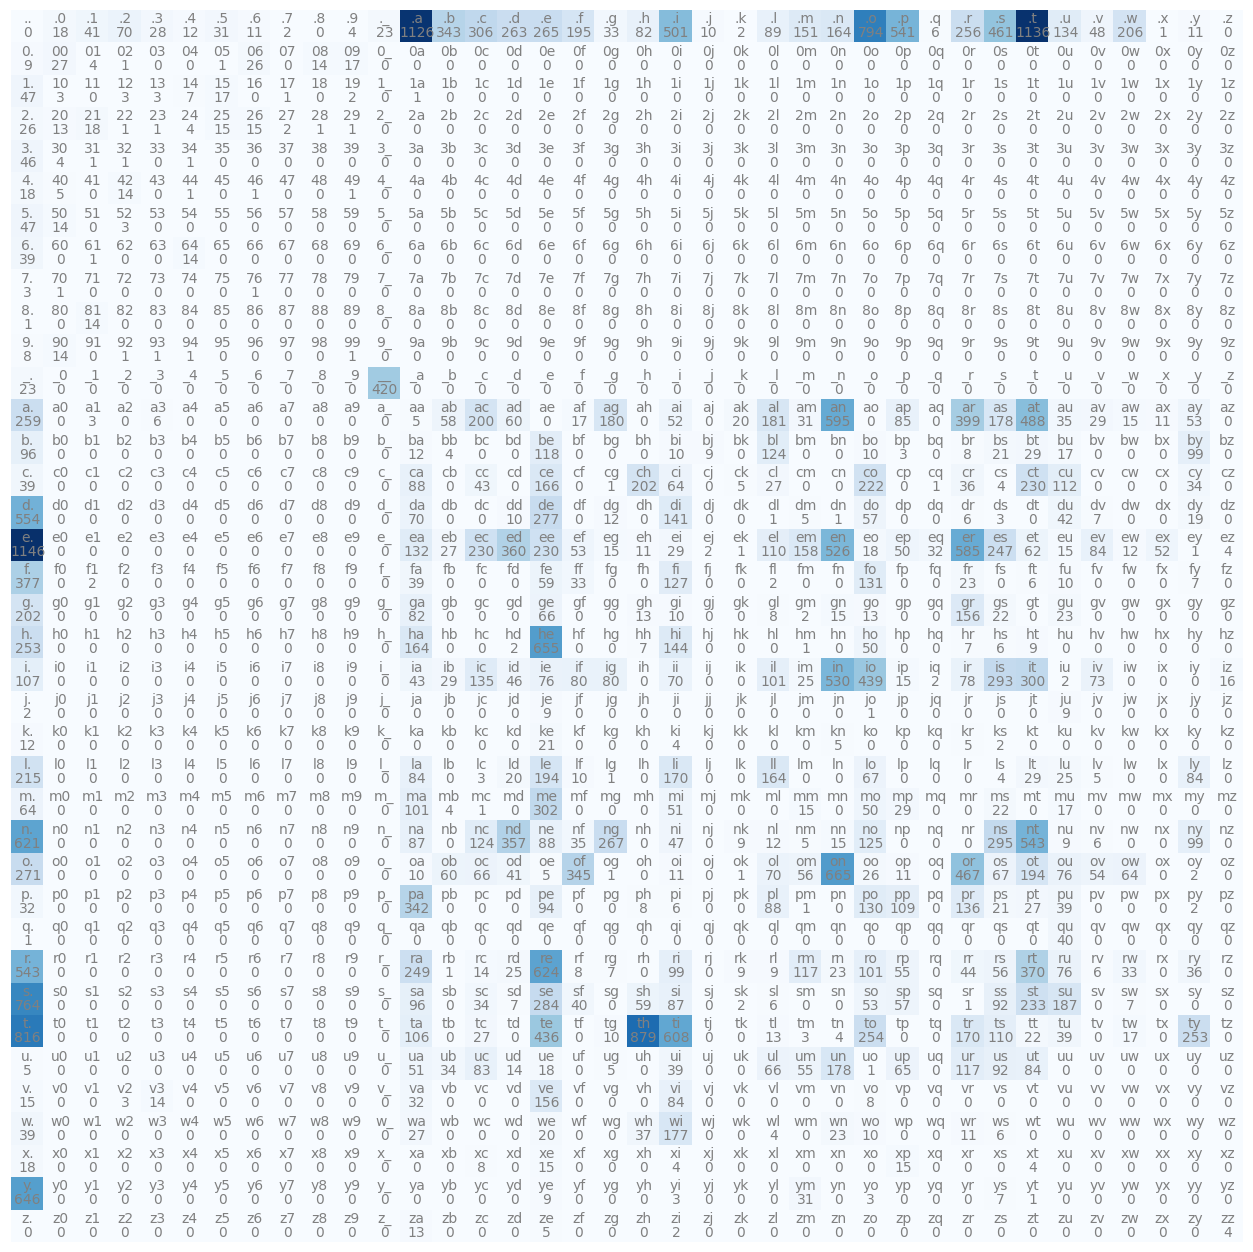

In [ ]:
for w in raw_text:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] +=1

import matplotlib.pyplot as plt
# %matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(number_unique_char):
    for j in range(number_unique_char):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.show()

In [66]:
# bigrams method
P = (N+1).float()
P = P / P.sum(1, keepdims=True)
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
log_likelihood = 0.0
n = 0
for w in raw_text:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll/n=}')

ult.
ovede.
itrevior.
everor.
poptre.
log_likelihood=tensor(-95517.1094)
nll/n=tensor(2.2408)


In [59]:
xs, ys = [], []
for w in raw_text[:1]: 
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=number_unique_char).float()
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((number_unique_char, number_unique_char), generator=g)
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1, keepdims=True)

# real optimization
xs, ys = [], []
for w in raw_text:
    chs = ['.'] +list(w)+ ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
# initializing the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((number_unique_char, number_unique_char), generator=g, requires_grad=True)
# gradient descent
for k in range(1000):
    # forward pass
    xenc = F.one_hot(xs, num_classes=number_unique_char).float()
    logits = xenc @ W
    # softmax
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    # CrossEntropy + regularization
    loss = -probs[torch.arange(num), ys].log().mean()+0.01*(W**2).mean()
    print(loss.item())
    # backward pass
    W.grad = None
    loss.backward()
    # Update W
    W.data += -50*W.grad
# predict/ sample
g = torch.Generator().manual_seed(2147483647)
for i in range(5):

    out = []
    ix = 0
    while True:

        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=number_unique_char).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

4.083583354949951
3.6052677631378174
3.29775071144104
3.0956530570983887
2.9581005573272705
2.8582229614257812
2.7840945720672607
2.727733612060547
2.6831839084625244
2.6466188430786133
2.6157875061035156
2.5893101692199707
2.566272020339966
2.546031951904297
2.5281217098236084
2.5121874809265137
2.4979467391967773
2.4851701259613037
2.4736616611480713
2.46325421333313
2.4538044929504395
2.445189952850342
2.437304973602295
2.430061101913452
2.4233827590942383
2.417205810546875
2.411475896835327
2.406146287918091
2.401176929473877
2.396533250808716
2.3921844959259033
2.388103485107422
2.384267568588257
2.3806545734405518
2.3772454261779785
2.374022960662842
2.370971918106079
2.3680784702301025
2.3653295040130615
2.362713575363159
2.3602209091186523
2.3578412532806396
2.35556697845459
2.3533902168273926
2.3513033390045166
2.349301338195801
2.347377061843872
2.3455264568328857
2.3437442779541016
2.342026472091675
2.340369462966919
2.33876895904541
2.337222099304199
2.335726022720337
2.334

In [68]:
# build the datasets
block_size = 3
X, Y = [], []
for w in raw_text:
    # print(w)
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print('.'.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
def build_dataset(raw_text):
    X, Y = [], []
    for w in raw_text:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(raw_text)
n1 = int(0.8 * len(raw_text))
n2 = int(0.9 * len(raw_text))

Xtr, Ytr = build_dataset(raw_text[:n1])
Xdev, Ydev = build_dataset(raw_text[n1:n2])
Xte, Yte = build_dataset(raw_text[n2:])

torch.Size([34026, 3]) torch.Size([34026])
torch.Size([4338, 3]) torch.Size([4338])
torch.Size([4263, 3]) torch.Size([4263])


14418
      0/ 200000: 3.6414
  10000/ 200000: 1.2567
  20000/ 200000: 1.7968
  30000/ 200000: 0.9780
  40000/ 200000: 1.1045
  50000/ 200000: 2.0109
  60000/ 200000: 1.3159
  70000/ 200000: 1.4028
  80000/ 200000: 0.9968
  90000/ 200000: 1.2200
 100000/ 200000: 1.4277
 110000/ 200000: 1.5152
 120000/ 200000: 1.2813
 130000/ 200000: 1.1621
 140000/ 200000: 1.4835
 150000/ 200000: 1.3479
 160000/ 200000: 1.2309
 170000/ 200000: 1.3731
 180000/ 200000: 0.8874
 190000/ 200000: 1.2783
train 1.161643147468567
val 1.1944637298583984


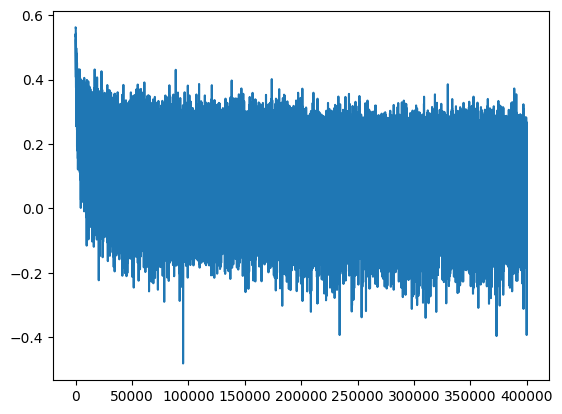

In [71]:
# MLP
vocab_size = number_unique_char
n_embd = 10
n_hidden = 200
mini_batch_size = 32
max_steps = 200000
W1_layers = n_embd * block_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((W1_layers, n_hidden), generator=g) * (5/3)/((W1_layers)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
stepi = []
lossi = []
for i in range(200000):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 # + b1
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
plt.plot(lossi)

# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [72]:
for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

sections.
effrse.
50906.
thissumpsett4m.
4q.
the.
a.
5.
5.
1.
expch.
___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________.
whpecifmccnition.
4q.
f1.
inc.
iv.
this.
iv.
whnlfcwouv_l.


In [ ]:
# predict/ sample
g = torch.Generator().manual_seed(2147483647)
for i in range(5):

    out = []
    ix = 0
    while True:

        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=number_unique_char).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

ult.
ovede.
itrevior.
everor.
poptre.


In [83]:
# dataset loader
class CharDataset(Dataset):

    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()} # inverse mapping

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1 # all the possible characters and special 0 token

    def get_output_length(self):
        return self.max_word_length + 1 # <START> token followed by words

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 # index -1 will mask the loss at the inactive locations
        return x, y

def create_datasets(input_file):

    # preprocessing of the input text file
    reader = PdfReader(input_file)
    for i in range(len(reader.pages)):
        page = reader.pages[i]
        global text
        text = text + page.extract_text()
    words = re.sub(r'[^\w]', ' ', text).lower().split()
    chars = sorted(list(set(re.sub(r'[^\w]', ' ', text).lower()))) # all the possible characters
    number_unique_char =len(chars)
    max_word_length = max(len(w) for w in words)
    print(f"number of examples in the dataset: {len(words)}")
    print(f"max word length: {max_word_length}")
    print(f"number of unique characters in the vocabulary: {number_unique_char}")
    print("vocabulary:")
    print(''.join(chars))

    # partition the input data into a training and the test set
    test_set_size = min(1000, int(len(words) * 0.1)) # 10% of the training set, or up to 1000 examples
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset

class InfiniteDataLoader:
    """
    this is really hacky and I'm not proud of it, but there doesn't seem to be
    a better way in PyTorch to just create an infinite dataloader?
    """

    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

In [84]:
train_dataset, test_dataset = create_datasets('ISDA.pdf')

number of examples in the dataset: 21254
max word length: 41
number of unique characters in the vocabulary: 38
vocabulary:
 0123456789_abcdefghijklmnopqrstuvwxyz
split up the dataset into 20254 training examples and 1000 test examples


In [87]:
from dataclasses import dataclass
@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4

In [86]:
# MLP language model

class MLP(nn.Module):
    """
    takes the previous block_size tokens, encodes them with a lookup table,
    concatenates the vectors and predicts the next token with an MLP.

    Reference:
    Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.wte = nn.Embedding(config.vocab_size + 1, config.n_embd) # token embeddings table
        # +1 in the line above for a special <BLANK> token that gets inserted if encoding a token
        # before the beginning of the input sequence
        self.mlp = nn.Sequential(
            nn.Linear(self.block_size * config.n_embd, config.n_embd2),
            nn.Tanh(),
            nn.Linear(config.n_embd2, self.vocab_size)
        )

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):

        # gather the word embeddings of the previous 3 words
        embs = []
        for k in range(self.block_size):
            tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size # special <BLANK> token
            embs.append(tok_emb)

        # concat all of the embeddings together and pass through an MLP
        x = torch.cat(embs, -1) # (b, t, n_embd * block_size)
        logits = self.mlp(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss


In [88]:
# init datasets
train_dataset, test_dataset = create_datasets('ISDA.pdf')
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
print(f"dataset determined that: {vocab_size=}, {block_size=}")

# init model
config = ModelConfig(vocab_size=vocab_size, block_size=block_size,
                       n_layer=4, n_head=4,
                       n_embd=64, n_embd2=64)

number of examples in the dataset: 28199
max word length: 41
number of unique characters in the vocabulary: 38
vocabulary:
 0123456789_abcdefghijklmnopqrstuvwxyz
split up the dataset into 27199 training examples and 1000 test examples
dataset determined that: vocab_size=39, block_size=42


In [89]:
model = MLP(config)

In [96]:
# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

# init dataloader
batch_loader = InfiniteDataLoader(train_dataset, batch_size=32, pin_memory=True, num_workers=4)

# training loop
best_loss = None
step = 0
while True:

    t0 = time.time()

    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to('mps') for t in batch]
    X, Y = batch

    # feed into the model
    logits, loss = model(X, Y)

    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    t1 = time.time()

    # logging
    if step % 10 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")


AttributeError: module 'torch._subclasses' has no attribute 'functional_tensor'

In [97]:
torch.__version__


'2.1.2'

In [93]:
pip install torch==2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.1 MB/s  0:00:04 eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.16.2 requires torch==2.1.2, but you have torch 2.2.0 which is incompatible.
torchaudio 2.1.2 requires torch==2.1.2, but you have torch 2.2.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
